In [5]:

import sys
import time
import os
import math
import cv2
import matplotlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ToTimeSeries import ToTimeSeries as ts_main


In [2]:
INTERVALS_LOWER_BOUND = 0
INTERVALS_UPPER_BOUND = 257
INTERVALS_SKIP_VALUE = 8
CUT_FILE = 0
FRAMES_IN_MEMORY = 2
BIN_SIZE = 4
DELTA_MAX_VALUE = 30
DELTA_MIN_VALUE = -30
DELTA_BINS_NUM = 61


INTERVALS = np.arange(INTERVALS_LOWER_BOUND, INTERVALS_UPPER_BOUND, INTERVALS_SKIP_VALUE)
DELTAS = np.linspace(DELTA_MIN_VALUE, DELTA_MAX_VALUE, num=DELTA_BINS_NUM)

delta_distribution_per_interval = np.zeros((len(INTERVALS), len(DELTAS)))
previous_bin_frame_averages = None

# PLOTTING PARAMETERS
MAX_COLOR = 0.1
LABEL_FONT_SIZE = 15
LABEL_OUT_OF_AXIS_PARAM = 15
FONT_SIZE = 50
EVERY_X_LABEL_TO_PRINT = 8
EVERY_Y_LABEL_TO_PRINT = 4
print("done")

done


In [3]:
def _in_which_interval(val, intervals):
    idx = np.where((intervals <= val))
    idx = idx[0][len(idx[0])-1]
    return idx     

def _which_delta(val, deltas):
    # array = np.asarray(deltas)
    idx = (np.abs(deltas - val)).argmin()
    return idx

print("done")

# FUNCTIONS:
def _count_deltas(frame_count, buf_bins, bin_number):
    global previous_bin_frame_averages
    if previous_bin_frame_averages is not None :
        bin_ctr = 0
        while bin_ctr < bin_number:
            frame_ctr = 0
            while frame_ctr < frame_count -1:
                # getting the average previously calculated
                
                bin_current_frame_average = previous_bin_frame_averages[bin_ctr]
                bin_next_frame_average = np.average(buf_bins[bin_ctr][frame_ctr+1])
                
                # updating the average for the next set of frames
                previous_bin_frame_averages[bin_ctr] = bin_next_frame_average
                
                current_bin_avgs_delta = bin_next_frame_average - bin_current_frame_average
                bin_current_interval = _in_which_interval(bin_current_frame_average, INTERVALS)
                bin_current_delta_index = _which_delta(current_bin_avgs_delta, DELTAS)
                delta_distribution_per_interval[bin_current_interval][bin_current_delta_index] += 1
                
                frame_ctr += 1
                
            bin_ctr+=1
    else:
        # if does not exist yet, create a new array
        previous_bin_frame_averages = np.zeros((bin_number))
        
        bin_ctr = 0
        while bin_ctr < bin_number:
            frame_ctr = 0
            while frame_ctr < frame_count -1:
                bin_current_frame_average = np.average(buf_bins[bin_ctr][frame_ctr])
                bin_next_frame_average = np.average(buf_bins[bin_ctr][frame_ctr+1])
                previous_bin_frame_averages[bin_ctr] = bin_next_frame_average
                current_bin_avgs_delta = bin_next_frame_average - bin_current_frame_average
                
                bin_current_interval = np.where((INTERVALS <= bin_current_frame_average))[0][-1]# _in_which_interval(bin_current_frame_average, INTERVALS)
                bin_current_delta_index = (np.abs(DELTAS - current_bin_avgs_delta)).argmin() #_which_delta(current_bin_avgs_delta, DELTAS)
                delta_distribution_per_interval[bin_current_interval][bin_current_delta_index] += 1
                
                frame_ctr += 1
                
            bin_ctr+=1
       
    
def _normalizing_deltas():
    interval_ctr=0
    while interval_ctr < len(INTERVALS)-1:
        current_interval_sum = np.sum(delta_distribution_per_interval[interval_ctr])
        if current_interval_sum == 0:
            current_interval_sum=1
        delta_distribution_per_interval[interval_ctr] = delta_distribution_per_interval[interval_ctr] / current_interval_sum
        interval_ctr += 1


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={"shrink":0.3}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=LABEL_FONT_SIZE, fontweight='bold')
    ax.set_yticklabels(row_labels, fontsize=LABEL_FONT_SIZE, fontweight='bold')

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="left",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    # for edge, spine in ax.spines.items():
    #     spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm((data[i, j])) > threshold)])
            text = im.axes.text(j, i,  "", **kw) # ORG: "{0:.4f}".format(deltas_distribution[i, j]), **kw)
            texts.append(text)

    return texts

 
def analyze_file(file_name):
    global delta_distribution_per_interval
    
    # LAST DIMENSION MUST DIVIDE 256 WITHOUT A REMAINDER. (THE POWER OF 2)
    delta_distribution_per_interval = np.zeros((len(INTERVALS), len(DELTAS)))
    
    cap = cv2.VideoCapture("ForAnalyze/{0}".format(file_name))
    final_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)    
    
    ret = True
    
    print("done")
    
    total_start = time.time()
    print("starting video {0}, frames: {1}".format(file_name, int(final_frame_count)))
    fc = 0
    buf = np.zeros((FRAMES_IN_MEMORY, frame_height, frame_width, 3), np.dtype('uint8'))
    
    while fc < final_frame_count - CUT_FILE - (FRAMES_IN_MEMORY-1) and ret:
        # loading the data according  
        in_memory_frames_ctr = 0
        while in_memory_frames_ctr < FRAMES_IN_MEMORY:
            if np.sum(buf[FRAMES_IN_MEMORY-1]) > 0:
                temp = buf[FRAMES_IN_MEMORY-1].copy()
                # clearing memory
                del buf
                
                buf = np.zeros((FRAMES_IN_MEMORY, frame_height, frame_width, 3), np.dtype('uint8'))
                buf[0] = temp.copy()
                del temp
            else:
                ret, frame = cap.read()
                buf[in_memory_frames_ctr] = frame
                fc += 1
            in_memory_frames_ctr += 1
        # fc += 1
        # converting the data to a single channel
        start = time.time()
        single_channel_buf = buf[:,:,:,:1].copy()
        # converting the data into bins
        ts = ts_main(bin_size=BIN_SIZE, original_file=single_channel_buf, frame_count=FRAMES_IN_MEMORY, single_frame_width=frame_width, single_frame_height=frame_height, channel_amount=1)
        buf_in_bins = ts.into_time_series()
        number_of_bins = ts.number_of_bins
        # counting the deltas
        _count_deltas(frame_count=len(buf), buf_bins=buf_in_bins, bin_number=number_of_bins)
        del single_channel_buf
        del buf_in_bins
        end = time.time()
        
        print("{0}: {1:.2f} seconds to count deltas".format(fc, end-start))
    del buf
    del frame
    del  ret  
        
        
    cap.release()
    total_end = time.time()
    print("{0}: {1:.2f} minutes total".format(fc, (total_end - total_start)/60))
    os.system('afplay alarm.m4a')
    print("done")
    
    start = time.time()
    _normalizing_deltas()
    end = time.time()
    print("{0} seconds to normalize deltas".format(end-start))
    
    # for figure presentation
    intervals_list = ["{0} >".format(inter) for inter in INTERVALS]
    deltas_list = DELTAS
    data = delta_distribution_per_interval[:]
    deltas_distribution = np.array(np.around(data, 6))
    
    fig, ax = plt.subplots(figsize=(2^16, 2^10))
    plt.title("EXP:{0}\nDelta distribution in Intervals\n Max Color data value = {1}".format(file_name, MAX_COLOR), fontsize=40)
    im, cbar = heatmap(deltas_distribution, intervals_list, np.around(deltas_list, 1), ax=ax,
                       cmap="YlGnBu", cbarlabel="Delta Distribution/ Gray Value Interval",vmax=MAX_COLOR)
    # setting the x labels
    # plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
    every_x_nth = EVERY_X_LABEL_TO_PRINT
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_x_nth != 0:
            label.set_visible(False)
            
    
    for n, line in enumerate(ax.xaxis.get_ticklines()):
        if n % every_x_nth != 0:
            line.set_visible(False)
    # setting the y labels 
    # plt.rc('ytick', labelsize=FONT_SIZE)   
    every_y_nth = EVERY_Y_LABEL_TO_PRINT
    for n, label in enumerate(ax.yaxis.get_ticklabels()):
        if n % every_y_nth != 0:
            label.set_visible(False)
    
    for n, line in enumerate(ax.yaxis.get_ticklines()):
        if n % every_y_nth != 0:
            line.set_visible(False)
    # ANNOTATE
    texts = annotate_heatmap(im, valfmt="{x:.3f}",
                           ha="center", va="center", fontsize=2)
    
    ax.tick_params(direction='out', pad=LABEL_OUT_OF_AXIS_PARAM)
    plt.tight_layout()
    fig.savefig('Heatmaps/{0}-heatmapMaxColor{1}__DeltaSpan{2}>>{3}.png'.format(file_name, MAX_COLOR,int(np.min(DELTAS)),int(np.max(DELTAS))), dpi=100)
    np.save('deltaDistributionArrays/{0}_delta_dist'.format(filename),delta_distribution_per_interval)
    print('saved plot file: {}'.format(file_name))
    os.system('clear')
    
    # del delta_distribution_per_interval
    

done


finished the following files: <generator object <genexpr> at 0x11715f390>
done
starting video PLT_coll4_exp.63_control_SP1.avi, frames: 154
2: 0.32 seconds to count deltas
3: 0.19 seconds to count deltas
4: 0.47 seconds to count deltas
5: 0.27 seconds to count deltas
6: 0.23 seconds to count deltas
7: 0.35 seconds to count deltas
8: 0.24 seconds to count deltas
9: 0.22 seconds to count deltas
10: 0.37 seconds to count deltas
11: 0.23 seconds to count deltas
12: 0.36 seconds to count deltas
13: 0.27 seconds to count deltas
14: 0.18 seconds to count deltas
15: 0.25 seconds to count deltas
16: 0.24 seconds to count deltas
17: 0.19 seconds to count deltas
18: 0.38 seconds to count deltas
19: 0.19 seconds to count deltas
20: 0.17 seconds to count deltas
21: 0.26 seconds to count deltas
22: 0.23 seconds to count deltas
23: 0.33 seconds to count deltas
24: 0.27 seconds to count deltas
25: 0.17 seconds to count deltas
26: 0.36 seconds to count deltas
27: 0.18 seconds to count deltas
28: 0.21 s

KeyboardInterrupt: 

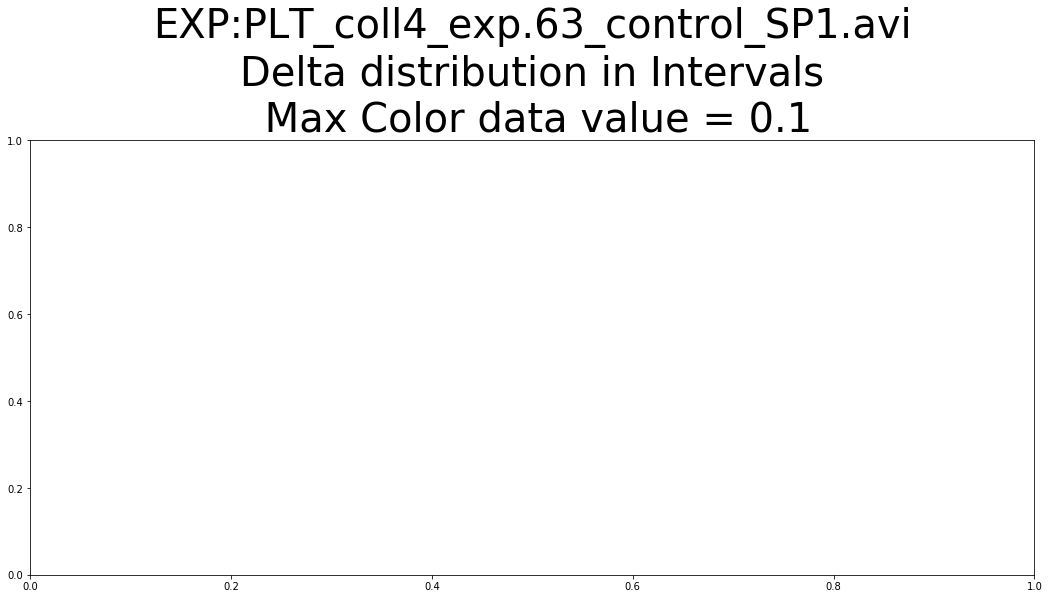

In [4]:
directory = os.fsencode("ForAnalyze")
total_files =""
finished_files = list()
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.mp4') or filename.endswith('.avi'):
        analyze_file(filename)
        finished_files.append(filename)
    print("finished the following files: {0}".format(total_files+", "+name for name in finished_files))
    

In [5]:
# for figure presentation
def show_different_max_color(data, name, max_color):
    intervals_list = ["{0} >".format(inter) for inter in INTERVALS]
    deltas_list = DELTAS
    deltas_distribution = np.array(np.around(data, 6))
    
    fig, ax = plt.subplots(figsize=(2^16, 2^10))
    plt.title("EXP:{0}\nDelta distribution in Intervals\n Max Color data value = {1}".format(name, max_color), fontsize=40)
    im, cbar = heatmap(deltas_distribution, intervals_list, np.around(deltas_list, 1), ax=ax,
                   cmap="YlGnBu", cbarlabel="Delta Distribution/ Gray Value Interval",vmax=max_color)
    # setting the x labels
    # plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
    every_x_nth = EVERY_X_LABEL_TO_PRINT
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_x_nth != 0:
            label.set_visible(False)
    
    
    for n, line in enumerate(ax.xaxis.get_ticklines()):
        if n % every_x_nth != 0:
            line.set_visible(False)
    # setting the y labels 
    # plt.rc('ytick', labelsize=FONT_SIZE)   
    every_y_nth = EVERY_Y_LABEL_TO_PRINT
    for n, label in enumerate(ax.yaxis.get_ticklabels()):
        if n % every_y_nth != 0:
            label.set_visible(False)
    
    for n, line in enumerate(ax.yaxis.get_ticklines()):
        if n % every_y_nth != 0:
            line.set_visible(False)
    # ANNOTATE
    texts = annotate_heatmap(im, valfmt="{x:.3f}",
                       ha="center", va="center", fontsize=2)
    
    ax.tick_params(direction='out', pad=LABEL_OUT_OF_AXIS_PARAM)
    plt.tight_layout()
    fig.savefig('Heatmaps/{0}-heatmapMaxColor{1}__DeltaSpan{2}>>{3}.png'.format(name, max_color, int(np.min(DELTAS)),int(np.max(DELTAS))), dpi=100)
    np.save('deltaDistributionArrays/{0}_delta_dist'.format(name),data)
    print('saved plot file: {}'.format(name))
    os.system('clear')

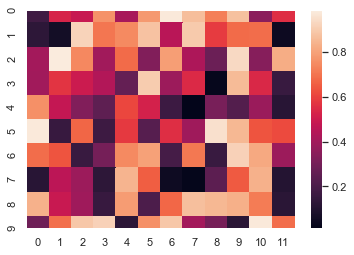

In [6]:
import seaborn as sns
sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data)